# Image classification with multilayer perceptron (MLP)

**Name**:

In this lab we design and train our first MLP network, and we use it for image classification.

In [91]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torchvision
import os
import matplotlib.pyplot as plt
import copy

## Dataset

We use the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, which is a large image dataset of hand-written digits.

<center><a href="https://en.wikipedia.org/wiki/MNIST_database">
    <img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"></a></center>

Just like some other widely-used datasets, MNIST can be downloaded directly from Pytorch, and includes specific commands to create a `Dataset` object, thus you don't have to do it manually as we did in lab 1.

In [92]:
# Dataset repository - remember to change it according to your folder structure
data_dir = '../datasets/'

# Choose one (or several) transform(s) to preprocess the data
# Here, we transform it to torch tensors, and we apply some normalization
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])

# Create a Dataset (you can download the data by setting 'download=True')
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)
num_classes = len(train_data.classes)
print('Number of classes in the dataset:', num_classes)

# We are not going to work with the full dataset (which is quite large), so we only keep small train and test subsets.
train_data = Subset(train_data, torch.arange(500))
test_data = Subset(test_data, torch.arange(50))
print('Number of images in the train dataset', len(train_data))
print('Number of images in the test dataset', len(test_data))

Number of classes in the dataset: 10
Number of images in the train dataset 500
Number of images in the test dataset 50


torch.Size([1, 28, 28])
Image label= 5


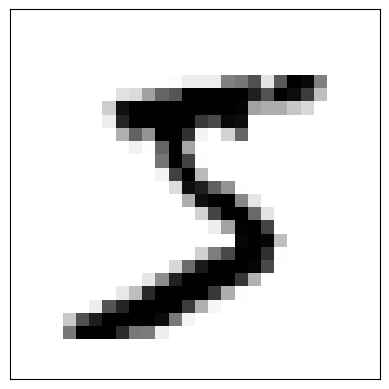

In [93]:
# Fetch one data pair (one image and the corresponding label)
image, label = train_data[0]
print(image.shape)
print('Image label=', label)

# The size of the image is [1, 28, 28], which corresponds to [num_channels, height, width]
# Indeed, MNIST images are in black-and-white (or grey scale) so there is only 1 color channel.
# To plot this image, let's remove this channel dimension by using squeeze()
plt.figure()
plt.imshow(image.squeeze(), cmap='gray_r')
plt.xticks([]), plt.yticks([])
plt.show()

In [94]:
# TO DO:
# - create two dataloaders (for the training and testing subsets) with a batch size of 8
batch_size = 8
train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size)
# - print the number of batches in the training subset
print('Number of batches in training:', len(train_dataloader))
print('Number of batches in test:', len(test_dataloader))

Number of batches in training: 63
Number of batches in test: 7


In [95]:
# Get a batch of images and corresponding labels from the train dataloader
batch_example = next(iter(train_dataloader))
image_batch_example = batch_example[0]
labels_batch_example = batch_example[1]

# Print the size of the batch of images and labels
print(image_batch_example.shape)
print(labels_batch_example.shape)

torch.Size([8, 1, 28, 28])
torch.Size([8])


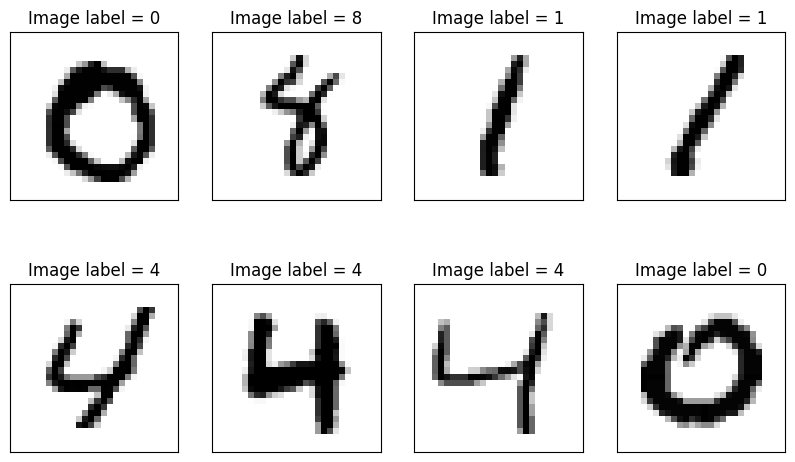

In [96]:
# Plot the images in the batch (along with the corresponding label)
plt.figure(figsize = (10,6))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib+1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(labels_batch_example[ib].item()))
plt.show()

## MLP network

A typical MLP network is composed of several layers:

- an *input* layer, which takes a batch of vectors and computes the first hidden representation.
- one or several *hidden* layers.
- an *output* layer, which computes the output of the network.

Each layer consists of a linear part and a non-linear *activation* functions (remember lab 2). There are many non-linear activation functions in Pytorch, check the [documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for a complete overview. A network is said to be *deep* if it has at least 3 layers (input, at least one hidden, and output).

<center><a href="https://www.researchgate.net/publication/309592737_Classification_of_VoIP_and_non-VoIP_traffic_using_machine_learning_approaches">
    <img src="https://www.researchgate.net/profile/Mouhammd-Alkasassbeh/publication/309592737/figure/fig2/AS:423712664100865@1478032379613/MultiLayer-Perceptron-MLP-sturcture-334-MultiLayer-Perceptron-Classifier-MultiLayer.png"></a></center>

**Note**: Since an MLP manipulates vectors (= 1D-tensors) as inputs, in image processing we first have to transform our images into vectors. For instance, if a black-and-white image is a (3D) tensor of size `[1, 28, 28]`, then we have to reshape it into a tensor of size `[1x28x28] = [784]`.


### Example

First, let's write each layer individually and apply them on the example batch `image_batch_example`.

In [97]:
# TO DO: reshape image_batch_example into a batch of vectors (=vectorized images):
vectorized_image = image_batch_example.reshape(image_batch_example.shape[0], -1)
print(vectorized_image.shape)
# 'image_batch_example' has size [batch_size, 1, 28, 28]
# 'vectorized_batch' should have size [batch_size, 1*28*28]



torch.Size([8, 784])


In [98]:
# Now we create the input layer (linear and activation) and we pass the vectorized batch through it
input_size = vectorized_image.shape[-1]
hidden_size = 10
input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), nn.Sigmoid())
y = input_layer(vectorized_image)
print(y.shape)

torch.Size([8, 10])


In [99]:
print(labels_batch_example.shape)

torch.Size([8])


Now, let's create the hidden and output layers.
- the hidden layer goes from `hidden_size` to `hidden_size`, and uses a Sigmoid activation function.
- the output layer goes from `hidden_size` to `output_size`, and uses no activation function.

**Note**: the output size is the number of classes in the dataset.

In [100]:
# TO DO:
# - create the hidden and output layers
hidden_layer = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.Sigmoid())
output_size = num_classes
out_layer = nn.Sequential(nn.Linear(hidden_size, output_size), nn.Sigmoid())
# out_layer = nn.Linear(hidden_size, output_size)
# - apply them to y to compute the output 'out'
y = hidden_layer(y)
out = out_layer(y)
# - print the size of 'out'
print(out.shape)

torch.Size([8, 10])


From what we have done above, two important remarks can be made:

- The output `out` has size `[batch_size, num_classes]` while the true labels `labels_batch_example` has size `[batch_size]`. This is because `out` contains a predicted probability for each class, while `labels_batch_example` simply contains the true labels.
- In classification tasks, we want to output *probabilities per class*. However, nothing ensures that `out` corresponds to probabilities, since it is not normalized and we didn't use any output activation function (values can be negative and not sum up to 1).

However, when training a classification network, we generally use the [Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) loss function, which alleviates these two issues. This loss is optimized for handling true labels instead of true probabilities per class, so you don't have to worry about it. Besides, it will automatically apply a [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) non-linearity to the predicted outputs, in order to normalize them as probabilities per class.

**Note**: Instead of Cross Entropy, you can use the [Negative log-likelihood](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) similarly. It will also solve the first problem, but then you need to manually add a [log Softmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax) as output activation to normalize the outputs.

In [101]:
# Choose Cross Entropy as loss function
loss_fn = nn.CrossEntropyLoss()

# Compute the error between the predicted labels 'out' and true labels 'labels_batch_example'
loss_batch = loss_fn(out, labels_batch_example)
print(loss_batch.item())

2.3435184955596924


### General module

Now, let's create a general MLP classification network. It's a python class that inherits from the general `nn.Module` object, and it should contain at least 2 methods:

- `__init__`, which initializes the network when instanciated (creates all the layers and stores some useful parameters if needed).
- `forward`, which applies the forward pass (i.e., applies the layers to the input in order to compute the output).

You can add other methods if needed but these two are sufficient for now.

**Note**: Remember that Python classes usually define and use some variables/data/tensors/dictionary etc. internally (this includes network layers) called *attributes*: they should be defined in the `__init__` method with a specific structure (the name should start by `self.`, as we did in lab 1). This allows you to access these attributes in other methods, such as *forward*, or after defining your network.

In [102]:
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super().__init__() # inherits methods from the parent class (= nn.Module)
        
        # TO DO: define the input, hidden, and output layers as before
        self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), act_fn)
        self.hidden_layer = nn.Sequential(nn.Linear(hidden_size, hidden_size), act_fn)
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        
        # TO DO: write the 'forward' method, which computes the output 'out' from the input x
        y = self.input_layer(x)
        y = self.hidden_layer(y)
        out = self.output_layer(y)
        # It should apply the input, hidden, and output layer, as we did in the example before.
        
        return out

<span style="color:red">**Exercice 1**</span> Instanciate an MLP classifier with a hidden size of 10 and a Sigmoid activation function. Use the provided function below to print the number of parameters in the model.

In [103]:
model = MLPClassif(input_size, hidden_size, output_size, nn.Sigmoid())

In [104]:
def print_num_params(model):
    print('Total number of parameters:', sum(p.numel() for p in model.parameters()))
    return

In [105]:
print(print_num_params(model))

Total number of parameters: 8070
None


### Initialization

It is important to properly initialize the network's parameters: this allows for reproducibity (avoid randomness), and might have a strong impact on the training process / final performance.

In [106]:
def init_params(m, seed=0):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return

model.apply(init_params)

MLPClassif(
  (input_layer): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (hidden_layer): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (output_layer): Linear(in_features=10, out_features=10, bias=True)
)

In [107]:
# Also remember (cf. lab 2) that you can save / load the model's parameters as follows:
torch.save(model.state_dict(), 'model_mlp_classif.pt')
model = MLPClassif(input_size, hidden_size, output_size, nn.Sigmoid())
model.load_state_dict(torch.load('model_mlp_classif.pt'))

/tmp/ipykernel_4652/3542072228.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_mlp_classif.pt'))


<All keys matched successfully>

## Training

We now write the function for training the network. It's very similar to what we did in lab 2, except now we process batches of data instead of the whole dataset at each epoch.

In [108]:
def training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    # print(model_tr.parameters())
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list for storing the training loss over epochs
    train_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        
        # Initialize the training loss for the current epoch
        tr_loss = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorize the images
            images = images.view(images.shape[0], -1)
            # - calculate the predicted labels from the vectorized images using 'model_tr'
            y = model_tr(images)
            # - using loss_fn, calculate the 'loss' between the predicted and true labels
            loss = loss_fn(y, labels)
            # - set the optimizer gradients at 0 for safety
            optimizer.zero_grad()
            # - compute the gradients (use the 'backward' method on 'loss')
            loss.backward()
            # - apply the gradient descent algorithm (perform a step of the optimizer)

            optimizer.step()
            # For each batch, we update the current epoch loss
            tr_loss += loss.item()

        # At the end of each epoch, get the average training loss over all batches
        tr_loss = tr_loss / len(train_dataloader)
        train_losses.append(tr_loss)
        
        # Display the training loss
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}'.format(epoch+1, num_epochs, tr_loss))
    
    return model_tr, train_losses

In [109]:
def training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list for storing the training loss over epochs
    train_losses = []

    # Initialize variables to keep track of the best model and best validation loss
    best_model = None
    best_val_loss = float('inf')
    
    # Training loop
    for epoch in range(num_epochs):
        
        # Initialize the training loss for the current epoch
        tr_loss = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorizing the images (size should be (batch_size, input_size))
            # - calculate the predicted labels from the vectorized images using 'model_tr'
            # - using loss_fn, calculate the 'loss' between the predicted and true labels
            # - set the optimizer gradients at 0 for safety
            # - compute the gradients (use the 'backward' method on 'loss')
            # - apply the gradient descent algorithm (perform a step of the optimizer)
            
            # Prepare the inputs and labels
            images = images.reshape(images.shape[0], -1)
            # print(images.shape)
            
            # Forward pass
            labels_predicted = model_tr(images)
            loss = loss_fn(labels_predicted, labels)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the current epoch loss
            # Note that 'loss.item()' is the loss averaged over the batch, so multiply it with the current batch size to get the total batch loss
            tr_loss += loss.item() * 8

             # If the current model has a lower validation loss, update the best model
            if loss < best_val_loss:
                best_val_loss = loss
            best_model = copy.deepcopy(model_tr)

        # Set the model back to training mode
        model_tr.train()

        # At the end of each epoch, get the average training loss and store it
        tr_loss = tr_loss/len(train_dataloader.dataset)
        train_losses.append(tr_loss)


        
        # Display the training loss
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}'.format(epoch+1, num_epochs, tr_loss))
    
    return best_model, train_losses

In [110]:
# TO DO: Define the training parameters and train the model
# - 30 epochs
# - learning rate = 0.01
# - loss function: Cross Entropy
# After training, save the model parameters and display the loss over epochs
num_epochs = 30

m, loss = training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, 0.01, verbose=True)
torch.save(m.state_dict(), 'mlp_class.pt')


Epoch [1/30], Training loss: 2.3616
Epoch [2/30], Training loss: 2.3180
Epoch [3/30], Training loss: 2.2927
Epoch [4/30], Training loss: 2.2709
Epoch [5/30], Training loss: 2.2550
Epoch [6/30], Training loss: 2.2418
Epoch [7/30], Training loss: 2.2291
Epoch [8/30], Training loss: 2.2170
Epoch [9/30], Training loss: 2.2043
Epoch [10/30], Training loss: 2.1932
Epoch [11/30], Training loss: 2.1816
Epoch [12/30], Training loss: 2.1690
Epoch [13/30], Training loss: 2.1572
Epoch [14/30], Training loss: 2.1468
Epoch [15/30], Training loss: 2.1345
Epoch [16/30], Training loss: 2.1246
Epoch [17/30], Training loss: 2.1141
Epoch [18/30], Training loss: 2.1023
Epoch [19/30], Training loss: 2.0923
Epoch [20/30], Training loss: 2.0798
Epoch [21/30], Training loss: 2.0689
Epoch [22/30], Training loss: 2.0552
Epoch [23/30], Training loss: 2.0439
Epoch [24/30], Training loss: 2.0316
Epoch [25/30], Training loss: 2.0196
Epoch [26/30], Training loss: 2.0068
Epoch [27/30], Training loss: 1.9941
Epoch [28/

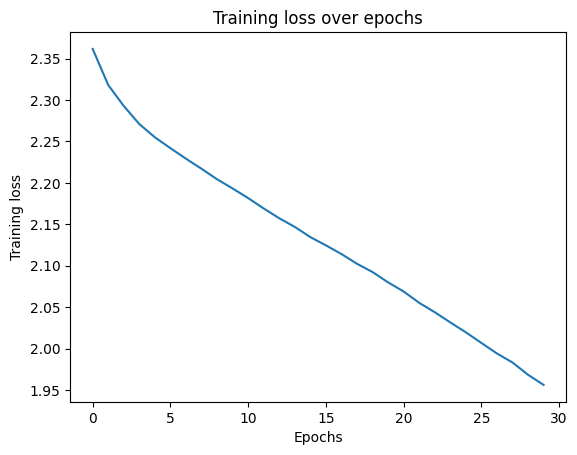

In [111]:
plt.figure()
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Training loss over epochs')
plt.show()

## Evaluation

Now the model is trained, we can evaluate it on the test dataset. We do that by predicting the labels using our model, and comparing it with the true labels. This allows us to compute the classification accuracy, which is provided in the function below.

<span style="color:red">**Exercice 2**</span> Evaluate the model on the test set. To do that, instanciate an MLP newtork and load the trained parameters. Then, apply the evaluation function using the test dataloader, and print the accuracy. Based on the plot above (training loss over epochs), can you suggest a way to improve the test accuracy?

<span style="color:red"> By increasing the number of epochs or using another activation function <span>

In [112]:
# Evaluation function: similar to the training loop, except we don't need to compute any gradient / backprop
def eval_mlp_classifier(model, eval_dataloader):
    
    # Set the model in 'evaluation' mode: this disables some layers (batch norm, dropout...) which are not needed when testing
    model.eval()

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels
            images = images.reshape(images.shape[0], -1)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [113]:
model = MLPClassif(input_size, hidden_size, output_size, nn.Sigmoid())
model.load_state_dict(torch.load('mlp_class.pt'))
accuracy = eval_mlp_classifier(model, test_dataloader)
print(f'Accuracy on test images is: {accuracy: 2f} %')

Accuracy on test images is:  52.000000 %


/tmp/ipykernel_4652/84282805.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mlp_class.pt'))


## Influence of the activation function

We used the MLP classifier with a Sigmoid activation function, but another common choice is the [Rectified Linear Unit](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU). Here we investigate how it performs compared to the Sigmoid-based network.

<span style="color:red">**Exercice 3**</span> Define an MLP classifier using ReLU activation, and initialize it. Train it (plot the training loss over epochs), and compute the test accuracy. Which one (Sigmoid or ReLU) do you recommend to use?

<span style="color:red">ReLU because it gives a better accuracy<span>

In [114]:
model_relu = MLPClassif(input_size, hidden_size, output_size, nn.ReLU())

In [115]:
torch.manual_seed(0)
model_relu.apply(init_params)

MLPClassif(
  (input_layer): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
  )
  (hidden_layer): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (output_layer): Linear(in_features=10, out_features=10, bias=True)
)

Epoch [1/30], Training loss: 2.0450
Epoch [2/30], Training loss: 1.5693
Epoch [3/30], Training loss: 1.2653
Epoch [4/30], Training loss: 1.0113
Epoch [5/30], Training loss: 0.8124
Epoch [6/30], Training loss: 0.6609
Epoch [7/30], Training loss: 0.5608
Epoch [8/30], Training loss: 0.4772
Epoch [9/30], Training loss: 0.4079
Epoch [10/30], Training loss: 0.3528
Epoch [11/30], Training loss: 0.3019
Epoch [12/30], Training loss: 0.2728
Epoch [13/30], Training loss: 0.2353
Epoch [14/30], Training loss: 0.2164
Epoch [15/30], Training loss: 0.1834
Epoch [16/30], Training loss: 0.1673
Epoch [17/30], Training loss: 0.1474
Epoch [18/30], Training loss: 0.1330
Epoch [19/30], Training loss: 0.1222
Epoch [20/30], Training loss: 0.1108
Epoch [21/30], Training loss: 0.1026
Epoch [22/30], Training loss: 0.0942
Epoch [23/30], Training loss: 0.0864
Epoch [24/30], Training loss: 0.0816
Epoch [25/30], Training loss: 0.0737
Epoch [26/30], Training loss: 0.0681
Epoch [27/30], Training loss: 0.0631
Epoch [28/

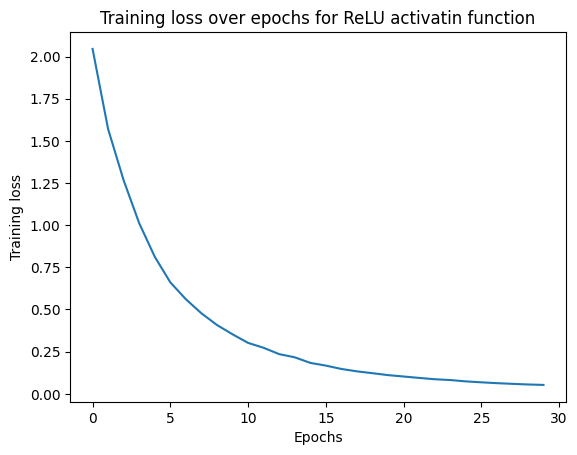

In [116]:
model_r, loss_relu = training_mlp_classifier(model_relu, train_dataloader, num_epochs, loss_fn, 0.01, verbose=True)
torch.save(model_r.state_dict(), 'model_mlp_classif_relu.pt')

plt.figure()
plt.plot(loss_relu)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.title('Training loss over epochs for ReLU activatin function')
plt.show()

In [117]:
model = MLPClassif(input_size, hidden_size, output_size, nn.ReLU())
model.load_state_dict(torch.load('model_mlp_classif_relu.pt'))
accuracy = eval_mlp_classifier(model, test_dataloader)
print(f'Accuracy on test images is: {accuracy: 2f} %')

Accuracy on test images is:  80.000000 %


/tmp/ipykernel_4652/564075210.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_mlp_classif_relu.pt'))


## Increasing the model capacity

In order to improve performance, a straightforward approach is to increase the model capacity, i.e., increase the number of parameters. There are basically two ways to do so: either increase the number of neurons in each layer (*width*) of increase the total number of layers (*depth*). Let's focus here on width.

<span style="color:red">**Exercice 4**</span> For each value of `hidden_size` in $[5, 10, 100, 200]$:
- instanciate (and initialize) an MLP classifier (it uses a ReLU activation)
- train the network (same training setup as before)
- print the number of parameters
- compute and display the test accuracy

Which value of `hidden_size` would you use and why?

In [118]:
hidden_sizes = [5, 10, 100, 200]
for hidden_size in hidden_sizes:
    model = MLPClassif(input_size, hidden_size, output_size, nn.ReLU())
    model.apply(init_params)
    model, loss_relu = training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, 0.01, verbose=False)
    accuracy = eval_mlp_classifier(model, test_dataloader)
    print(f'Accuracy on test images with hidden size {hidden_size} is: {accuracy: 2f} %')
    print_num_params(model)

Accuracy on test images with hidden size 5 is:  64.000000 %
Total number of parameters: 4015
Accuracy on test images with hidden size 10 is:  80.000000 %
Total number of parameters: 8070
Accuracy on test images with hidden size 100 is:  92.000000 %
Total number of parameters: 89610
Accuracy on test images with hidden size 200 is:  92.000000 %
Total number of parameters: 199210


<span style="color:red">I'd use hidden size 100 because with less number of parameters than 200, it gives thesame accuracy and better accuracy than  5 and 10 <span>